## New markdown cell

# AlexNet

## Download Tiny ImageNet

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

In [ ]:
!unzip tiny-imagenet-200.zip

## Setup

In [52]:
!pip install tensorflow pillow pydot> /dev/null

In [1]:
import numpy as np
import os
from shutil import copyfile, rmtree
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Loading Data

In [2]:
IMG_DIR = 'tiny-imagenet-200'
IMG_HEIGHT = IMG_WIDTH = 227
BATCH_SIZE = 128

In [3]:
# Get list of class of words
words_file = open(f'{IMG_DIR}/words.txt')
words = words_file.readlines()
class_words = {word.split('\t')[0]: word.split('\t')[1] for word in words}

In [4]:
# Get list of classes from val
val_text_file = open(f'{IMG_DIR}/val/val_annotations.txt')
lines = val_text_file.readlines()
val_classes = [(line.split('\t')[1], line.split('\t')[0]) for line in lines]

In [5]:
# Copy files from images directory to class folders
VAL_DIR = f'{IMG_DIR}/val'
VAL_IMAGE_DIR = f'{VAL_DIR}/images'
if os.path.exists(VAL_IMAGE_DIR):
    for val_class, img_name in val_classes:
        CLASS_DIR = f'{VAL_DIR}/{val_class}'
        if not os.path.exists(CLASS_DIR):
            os.mkdir(CLASS_DIR)

        src_img = f'{VAL_IMAGE_DIR}/{img_name}'
        dest_img = f'{CLASS_DIR}/{img_name}'
        copyfile(src_img, dest_img)

    # Remove images directory
    rmtree(VAL_IMAGE_DIR)
else:
    print('Validation file structure already setup')

Validation file structure already setup


In [34]:
train_ds = keras.preprocessing.image_dataset_from_directory(
  f'{IMG_DIR}/train', image_size=(IMG_HEIGHT, IMG_WIDTH),  batch_size=BATCH_SIZE, label_mode='categorical')

Found 100000 files belonging to 200 classes.


In [35]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    f'{IMG_DIR}/val', image_size=(IMG_HEIGHT, IMG_WIDTH),  batch_size=BATCH_SIZE, label_mode='categorical')

Found 10000 files belonging to 200 classes.


In [36]:
# Sanity check
train_ds.class_names == val_ds.class_names

True

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  


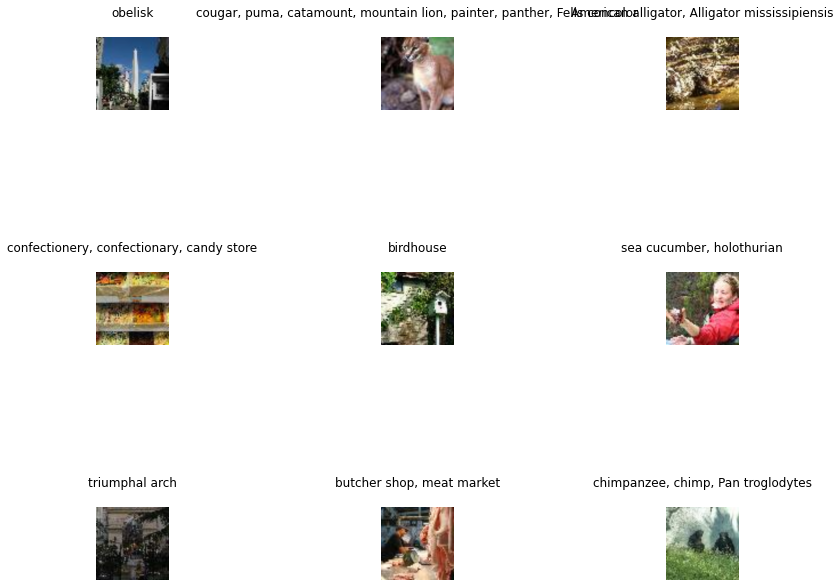

In [37]:
train_class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_words[train_class_names[np.argmax(labels[i], axis=-1)]])
        plt.tight_layout()
        plt.axis("off")

## Data Augmentation 
1. Image translation and horizontal reflection [WIP]
2. Altering RGB intensities [WIP]

In [38]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(227,227),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.Rescaling(1.0 / 255)
    ]
)

In [39]:
# Source: https://jkjung-avt.github.io/keras-image-cropping/

# def random_crop(img, random_crop_size):
#     # Note: image_data_format is 'channel_last'
#     assert img.shape[2] == 3
#     height, width = img.shape[0], img.shape[1]
#     dy, dx = random_crop_size
#     x = np.random.randint(0, width - dx + 1)
#     y = np.random.randint(0, height - dy + 1)
#     return img[y:(y+dy), x:(x+dx), :]


# def crop_generator(batches, crop_length):
#     """Take as input a Keras ImageGen (Iterator) and generate random
#     crops from the image batches generated by the original iterator.
#     """
#     while True:
#         batch_x, batch_y = next(batches)
#         batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
#         for i in range(batch_x.shape[0]):
#             batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
#         yield (batch_crops, batch_y)

In [40]:
# train_datagen = ImageDataGenerator(horizontal_flip=True)
# train_generator = train_datagen.flow_from_directory(
#     'tiny-imagenet-200/train', 
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     color_mode='rgb',
#     batch_size=BATCH_SIZE,
#     class_mode='categorical'
# )
#train_ds = crop_generator(train_batches, 224)

In [41]:
# As part of model -> better with GPU
# inputs = keras.Input(shape=input_shape)
# x = data_augmentation(inputs)
# x = layers.experimental.preprocessing.Rescaling(1./255)(x)

# Augmenting data set separately -> better with CPU
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
augmented_val_ds = val_ds.map(lambda x, y: (data_augmentation(x), y))

In [42]:
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
augmented_val_ds = augmented_val_ds.prefetch(buffer_size=32)

In [43]:
augmented_train_ds.take(1)

<TakeDataset shapes: ((None, 227, 227, 3), (None, 200)), types: (tf.float32, tf.float32)>

## Make model

![AlexNet](assets/AlexNetMerged.png)

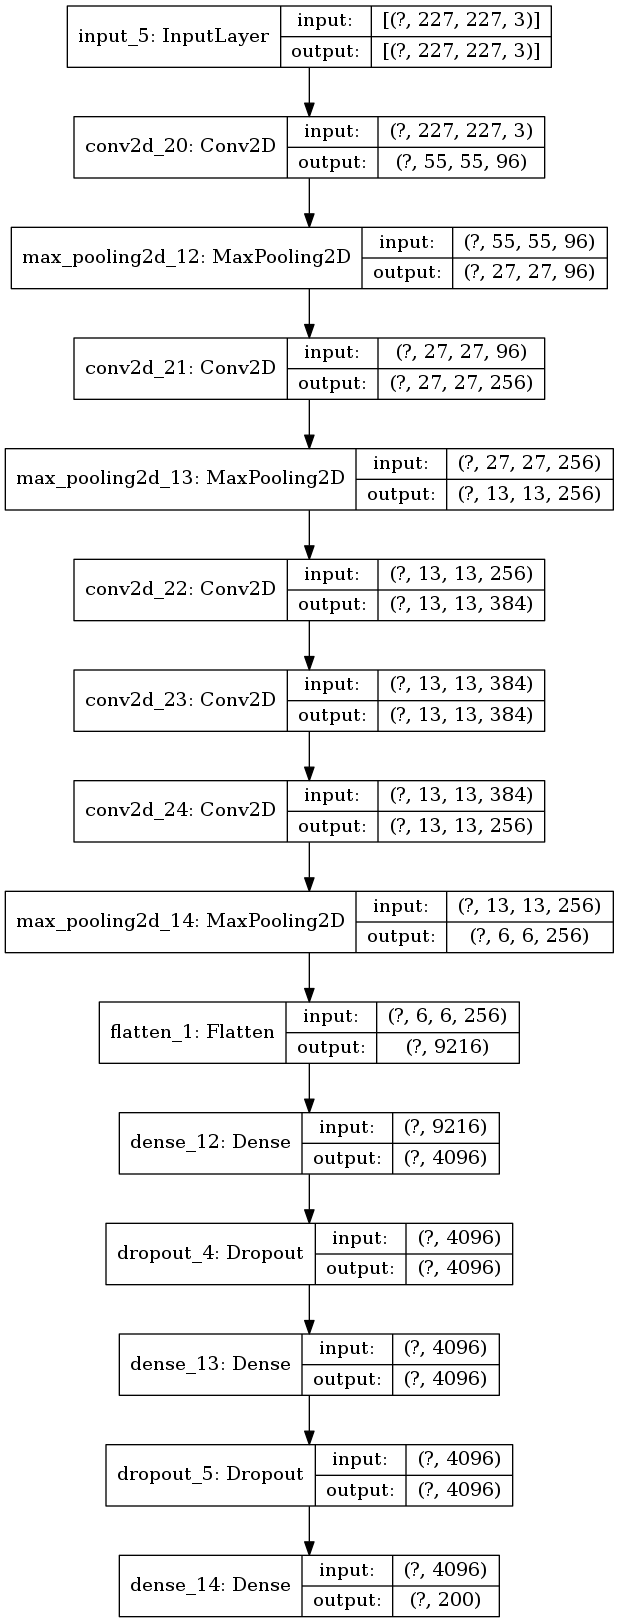

In [44]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(filters=96, kernel_size=(11,11), strides=4, padding='valid', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=2)(x)

    x = layers.Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=2)(x)

    x = layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu')(x)
    
    x = layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu')(x)

    x = layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(3,3), strides=2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = make_model(input_shape=(227,227, 3), num_classes=200)
keras.utils.plot_model(model, show_shapes=True)

## Training the model

In [21]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=["accuracy"],
)
model.fit(
    augmented_train_ds, epochs=epochs, callbacks=callbacks, validation_data=augmented_val_ds,
)

## To be continued...
https://keras.io/examples/vision/image_classification_from_scratch/

https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/